In [1]:
import numpy as np
import pandas as pd 
import gc
gc.enable()

In [2]:
order_products_train = pd.read_csv(r"C:\Users\Don\Downloads\instacart-market-basket-analysis\order_products__train.csv\order_products__train.csv")
order_products_prior = pd.read_csv(r"C:\Users\Don\Downloads\instacart-market-basket-analysis\order_products__prior.csv\order_products__prior.csv")
orders = pd.read_csv(r"C:\Users\Don\Downloads\instacart-market-basket-analysis\orders.csv\orders.csv")
products = pd.read_csv(r"C:\Users\Don\Downloads\instacart-market-basket-analysis\products.csv\products.csv")
aisles = pd.read_csv(r"C:\Users\Don\Downloads\instacart-market-basket-analysis\aisles.csv\aisles.csv")
departments = pd.read_csv(r"C:\Users\Don\Downloads\instacart-market-basket-analysis\departments.csv\departments.csv")

In [3]:
def reduce_mem_usage(train_data):
 
    start_mem = train_data.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))

    for col in train_data.columns:
        col_type = train_data[col].dtype

        if col_type != object:
            c_min = train_data[col].min()
            c_max = train_data[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    train_data[col] = train_data[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    train_data[col] = train_data[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    train_data[col] = train_data[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    train_data[col] = train_data[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    train_data[col] = train_data[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    train_data[col] = train_data[col].astype(np.float32)
                else:
                    train_data[col] = train_data[col].astype(np.float64)
        else:
            train_data[col] = train_data[col].astype('category')
        end_mem = train_data.memory_usage().sum() / 1024**2
        print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
        print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return train_data


In [4]:
reduce_mem_usage(order_products_prior)
reduce_mem_usage(order_products_train)
reduce_mem_usage(products)
reduce_mem_usage(orders)
reduce_mem_usage(departments)
reduce_mem_usage(aisles)

Memory usage of dataframe is 989.82 MB
Memory usage after optimization is: 866.09 MB
Decreased by 12.5%
Memory usage after optimization is: 742.37 MB
Decreased by 25.0%
Memory usage after optimization is: 556.78 MB
Decreased by 43.7%
Memory usage after optimization is: 340.25 MB
Decreased by 65.6%
Memory usage of dataframe is 42.26 MB
Memory usage after optimization is: 36.97 MB
Decreased by 12.5%
Memory usage after optimization is: 31.69 MB
Decreased by 25.0%
Memory usage after optimization is: 22.45 MB
Decreased by 46.9%
Memory usage after optimization is: 13.20 MB
Decreased by 68.7%
Memory usage of dataframe is 1.52 MB
Memory usage after optimization is: 1.33 MB
Decreased by 12.5%
Memory usage after optimization is: 2.52 MB
Decreased by -66.5%
Memory usage after optimization is: 2.24 MB
Decreased by -47.7%
Memory usage after optimization is: 1.91 MB
Decreased by -25.8%
Memory usage of dataframe is 182.71 MB
Memory usage after optimization is: 169.66 MB
Decreased by 7.1%
Memory usage

,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation
...,...,...
129,130,hot cereal pancake mixes
130,131,dry pasta
131,132,beauty
132,133,muscles joints pain relief


In [5]:
#We keep prior orders
users = orders[orders['eval_set'] == 'prior']
users['days_since_prior_order'].dropna()

# We group orders by user_id & calculate the variables based on different user_id
users = users.groupby('user_id').agg(user_orders= ('order_number' , max),user_period=('days_since_prior_order', sum),user_mean_days_since_prior = ('days_since_prior_order','mean'))
users.head()

,user_orders,user_period,user_mean_days_since_prior
user_id,,,
1,10,176.0,19.562500
2,14,198.0,15.234375
3,12,133.0,12.093750
4,5,55.0,13.750000
5,4,40.0,13.335938


In [6]:
# We create a new table "orders_products" which contains the tables "orders" and "order_products_prior"
orders_products =pd.merge(orders , order_products_prior, on='order_id', how='inner')

# Getting the number of products in each basket(order)
groupedorders_products = orders_products.groupby(['order_id']).agg(
    basket_size = ('product_id', 'count')
).reset_index()
orders_products = orders_products.merge(groupedorders_products, on='order_id', how='left')
orders_products.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,basket_size
0,2539329,1,prior,1,2,8,NaN,196,1,0,5
1,2539329,1,prior,1,2,8,NaN,14084,2,0,5
2,2539329,1,prior,1,2,8,NaN,12427,3,0,5
3,2539329,1,prior,1,2,8,NaN,26088,4,0,5
4,2539329,1,prior,1,2,8,NaN,26405,5,0,5


In [7]:
orders_products['p_reordered']= orders_products['reordered']==1
orders_products['non_first_order']= orders_products['order_number']>1

us=orders_products

# We group orders_products by user_id & calculate the variables based on different user_id
us=orders_products.groupby('user_id').agg(
    
     user_total_products =('user_id','count') ,
     p_reordered =('p_reordered', sum) ,
     non_first_order =('non_first_order', sum),
     user_distinct_products=('product_id','nunique')

).reset_index()
#    us['user_reorder_ratio'] = sum(reordered == 1) / sum(order_number > 1)
us['user_reorder_ratio']=us['p_reordered']/us['non_first_order']

del us["p_reordered"],us["non_first_order"]
del orders_products['p_reordered' ],orders_products['non_first_order']

us.head(20)

,user_id,user_total_products,user_distinct_products,user_reorder_ratio
0,1,59,18,0.759259
1,2,195,102,0.510989
2,3,88,33,0.705128
3,4,18,17,0.071429
4,5,37,23,0.538462
5,6,14,12,0.200000
6,7,206,68,0.711340
7,8,49,36,0.464286
8,9,76,58,0.391304
9,10,143,94,0.355072


In [8]:
users =pd.merge(users,us ,on='user_id',  how='inner')

# We calculate the user_average_basket variable
users['user_average_basket'] = users['user_total_products'] / users['user_orders']
users.head()

,user_id,user_orders,user_period,user_mean_days_since_prior,user_total_products,user_distinct_products,user_reorder_ratio,user_average_basket
0,1,10,176.0,19.562500,59,18,0.759259,5.900000
1,2,14,198.0,15.234375,195,102,0.510989,13.928571
2,3,12,133.0,12.093750,88,33,0.705128,7.333333
3,4,5,55.0,13.750000,18,17,0.071429,3.600000
4,5,4,40.0,13.335938,37,23,0.538462,9.250000


In [9]:
# we exclude prior orders and thus we keep only train and test orders
us = orders[orders['eval_set'] != 'prior']
us['time_since_last_order'] = us['days_since_prior_order']
us['future_order_dow'] = us['order_dow']
us['future_order_hour_of_day'] = us['order_hour_of_day']

us = us[['user_id','order_id','eval_set','time_since_last_order', 'future_order_dow', 'future_order_hour_of_day']]

# We combine users and us tables and store the results into the users table
users_features = pd.merge(users , us, on='user_id', how='inner') 

# We delete the us table
del us, users

users_features.head()

C:\Users\Don\AppData\Local\Temp\ipykernel_17628\739430334.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  us['time_since_last_order'] = us['days_since_prior_order']
C:\Users\Don\AppData\Local\Temp\ipykernel_17628\739430334.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  us['future_order_dow'] = us['order_dow']
C:\Users\Don\AppData\Local\Temp\ipykernel_17628\739430334.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_index

,user_id,user_orders,user_period,user_mean_days_since_prior,user_total_products,user_distinct_products,user_reorder_ratio,user_average_basket,order_id,eval_set,time_since_last_order,future_order_dow,future_order_hour_of_day
0,1,10,176.0,19.562500,59,18,0.759259,5.900000,1187899,train,14.0,4,8
1,2,14,198.0,15.234375,195,102,0.510989,13.928571,1492625,train,30.0,1,11
2,3,12,133.0,12.093750,88,33,0.705128,7.333333,2774568,test,11.0,5,15
3,4,5,55.0,13.750000,18,17,0.071429,3.600000,329954,test,30.0,3,12
4,5,4,40.0,13.335938,37,23,0.538462,9.250000,2196797,train,6.0,0,11


In [10]:
prod_features = orders_products.groupby(['product_id']).agg(
    prod_freq = ('order_id', 'count'),
    prod_avg_position = ('add_to_cart_order', 'mean')
#     prod_avg_hour = ('order_hour_of_day', average_times_of_day),
#     prod_avg_dow = ('order_dow', average_days)
).reset_index()

prod_features.head(20)

,product_id,prod_freq,prod_avg_position
0,1,1852,5.801836
1,2,90,9.888889
2,3,277,6.415162
3,4,329,9.507599
4,5,15,6.466667
5,6,8,14.125000
6,7,30,7.966667
7,8,165,8.418182
8,9,156,7.608974
9,10,2572,8.816874


In [11]:
#Probability a product is reordered after the first order
#On average how many times a product has been purchased by the users who purchased it at least once

In [12]:
non_first_order = orders_products['order_number'] != 1

groupedorders_products = orders_products[non_first_order].groupby(['product_id']).agg(
    prod_reorder_ratio = ('reordered', 'mean')
).reset_index()

prod_features = prod_features.merge(groupedorders_products, on='product_id', how='left')

# Group by users who have bought it more than once
# get the count of orders each user bought having the product. 
groupedorders_products = orders_products[non_first_order].groupby(['product_id', 'user_id']).agg(
    user_prod_freq = ('order_id', 'count')
).reset_index()

# get the avg # of orders the user will buy having that product after buying it for the first time
groupedorders_products = groupedorders_products.groupby(['product_id']).agg(
    user_prod_avg_freq = ('user_prod_freq', 'mean')
).reset_index()

prod_features = prod_features.merge(groupedorders_products, on='product_id', how='left')
del groupedorders_products, non_first_order

prod_features.head()

,product_id,prod_freq,prod_avg_position,prod_reorder_ratio,user_prod_avg_freq
0,1,1852,5.801836,0.647662,2.641566
1,2,90,9.888889,0.137931,1.160000
2,3,277,6.415162,0.780769,3.714286
3,4,329,9.507599,0.506897,1.746988
4,5,15,6.466667,0.642857,2.333333


In [13]:
#User x Product Predictors
#Creating predictors that indicate how a user behaves towards a specific product. 
#We store these predictors in the data table. 

#The four variables:
#up_orders:The total times a user ordered a product

#up_first_order: What was the first time a user purchased a product

#up_last_order: What was the last time a user purchased a product

#up_average_cart_position: The average position in a user's cart of a product

In [14]:
# We create the data table starting from the orders_products table 
data = orders_products

data = data.groupby(['user_id','product_id']).agg( up_orders= ('product_id', 'count'), up_first_order=('order_number', min), up_last_order = ('order_number',max),up_average_cart_position = ('add_to_cart_order','mean')).reset_index()
 
del orders_products
data.head(20)

,user_id,product_id,up_orders,up_first_order,up_last_order,up_average_cart_position
0,1,196,10,1,10,1.400000
1,1,10258,9,2,10,3.333333
2,1,10326,1,5,5,5.000000
3,1,12427,10,1,10,3.300000
4,1,13032,3,2,10,6.333333
5,1,13176,2,2,5,6.000000
6,1,14084,1,1,1,2.000000
7,1,17122,1,5,5,6.000000
8,1,25133,8,3,10,4.000000
9,1,26088,2,1,2,4.500000


In [15]:
# up_order_rate = up_orders / user_total_products
data = data.merge(users_features[['user_id','user_orders']], on='user_id' , how='left')
data['up_order_rate'] = data['up_orders']/data['user_orders']

# up_orders_since_last_order = user_last_order - user_last_ordered_that_product
data['up_orders_since_last_order'] = data['user_orders'] - data['up_last_order']

# From the moment the user bought a product, how frequent he then bought it in his next orders?
# up_order_rate_since_first_order = up_orders / (user_orders - up_first_order + 1)
# The + 1 is added since order_numbering starts from 1 not 0
data['up_order_rate_since_first_order'] = data['up_orders']/(data['user_orders'] - data['up_first_order'] + 1)
del data['user_orders']

data.head()

,user_id,product_id,up_orders,up_first_order,up_last_order,up_average_cart_position,up_order_rate,up_orders_since_last_order,up_order_rate_since_first_order
0,1,196,10,1,10,1.400000,1.0,0,1.000000
1,1,10258,9,2,10,3.333333,0.9,0,1.000000
2,1,10326,1,5,5,5.000000,0.1,5,0.166667
3,1,12427,10,1,10,3.300000,1.0,0,1.000000
4,1,13032,3,2,10,6.333333,0.3,0,0.333333


In [16]:
# Merging user and product features with the final features dataframe
data = data.merge(users_features, on='user_id', how='left').merge(prod_features, on='product_id', how='left')
del users_features, prod_features

order_products_future = order_products_train.merge(orders, on='order_id', how='left')
order_products_future = order_products_future[['user_id', 'product_id', 'reordered']]
data = data.merge(order_products_future, on=['user_id', 'product_id'], how='left')

# Set 0 to Product who didn't exists in the future order so model can predict them as Not in future order.
data['reordered'].fillna(0, inplace = True)

In [17]:
# Splitting data to train and test
X_train = data[data['eval_set'] == 'train']
y_train = X_train['reordered']
X_test = data[data['eval_set'] == 'test']
del data

In [18]:
X_train.head(10)

,user_id,product_id,up_orders,up_first_order,up_last_order,up_average_cart_position,up_order_rate,up_orders_since_last_order,up_order_rate_since_first_order,user_orders,...,order_id,eval_set,time_since_last_order,future_order_dow,future_order_hour_of_day,prod_freq,prod_avg_position,prod_reorder_ratio,user_prod_avg_freq,reordered
0,1,196,10,1,10,1.400000,1.0,0,1.000000,10,...,1187899,train,14.0,4,8,35791,3.721774,0.830301,4.425040,1.0
1,1,10258,9,2,10,3.333333,0.9,0,1.000000,10,...,1187899,train,14.0,4,8,1946,4.277492,0.740800,3.459410,1.0
2,1,10326,1,5,5,5.000000,0.1,5,0.166667,10,...,1187899,train,14.0,4,8,5526,4.191097,0.684851,2.851491,0.0
3,1,12427,10,1,10,3.300000,1.0,0,1.000000,10,...,1187899,train,14.0,4,8,6476,4.760037,0.780000,3.855799,0.0
4,1,13032,3,2,10,6.333333,0.3,0,0.333333,10,...,1187899,train,14.0,4,8,3751,5.622767,0.700881,2.918672,1.0
5,1,13176,2,2,5,6.000000,0.2,5,0.222222,10,...,1187899,train,14.0,4,8,379450,5.095947,0.876825,5.921473,0.0
6,1,14084,1,1,1,2.000000,0.1,9,0.100000,10,...,1187899,train,14.0,4,8,15935,5.792595,0.853341,5.276655,0.0
7,1,17122,1,5,5,6.000000,0.1,5,0.166667,10,...,1187899,train,14.0,4,8,13880,6.257421,0.719868,3.079433,0.0
8,1,25133,8,3,10,4.000000,0.8,0,1.000000,10,...,1187899,train,14.0,4,8,6196,7.001614,0.773095,3.846952,1.0
9,1,26088,2,1,2,4.500000,0.2,8,0.200000,10,...,1187899,train,14.0,4,8,2523,6.495838,0.576271,2.169118,1.0


In [19]:
X_test.head(10)

,user_id,product_id,up_orders,up_first_order,up_last_order,up_average_cart_position,up_order_rate,up_orders_since_last_order,up_order_rate_since_first_order,user_orders,...,order_id,eval_set,time_since_last_order,future_order_dow,future_order_hour_of_day,prod_freq,prod_avg_position,prod_reorder_ratio,user_prod_avg_freq,reordered
120,3,248,1,2,2,3.000000,0.083333,10,0.090909,12,...,2774568,test,11.0,5,15,6371,10.620782,0.425781,1.656250,0.0
121,3,1005,1,10,10,5.000000,0.083333,2,0.333333,12,...,2774568,test,11.0,5,15,463,9.498920,0.467890,1.809129,0.0
122,3,1819,3,4,7,2.666667,0.250000,5,0.333333,12,...,2774568,test,11.0,5,15,2424,9.287541,0.520733,1.968213,0.0
123,3,7503,1,3,3,6.000000,0.083333,9,0.100000,12,...,2774568,test,11.0,5,15,12474,9.547379,0.588361,2.235854,0.0
124,3,8021,1,2,2,5.000000,0.083333,10,0.090909,12,...,2774568,test,11.0,5,15,27864,8.822854,0.625456,2.451685,0.0
125,3,9387,5,1,7,3.600000,0.416667,5,0.416667,12,...,2774568,test,11.0,5,15,36187,7.476027,0.695497,2.893468,0.0
126,3,12845,1,4,4,2.000000,0.083333,8,0.111111,12,...,2774568,test,11.0,5,15,10027,10.444101,0.387128,1.570068,0.0
127,3,14992,2,6,7,7.000000,0.166667,5,0.285714,12,...,2774568,test,11.0,5,15,29069,9.240669,0.628832,2.399537,0.0
128,3,15143,1,1,1,3.000000,0.083333,11,0.083333,12,...,2774568,test,11.0,5,15,3447,8.714824,0.535692,2.012715,0.0
129,3,16797,3,1,9,4.000000,0.250000,3,0.250000,12,...,2774568,test,11.0,5,15,142951,7.116096,0.743177,3.293464,0.0


In [20]:
y_train.head(10)

0    1.0
1    1.0
2    0.0
3    0.0
4    1.0
5    0.0
6    0.0
7    0.0
8    1.0
9    1.0
Name: reordered, dtype: float64

In [21]:
from sklearn.model_selection import train_test_split

print('Class distribution before splitting')
pos_count = np.sum(X_train['reordered']==1)
neg_count = np.sum(X_train['reordered']==0)
print('positive ratio: ', pos_count)
print('negative count: ', neg_count)
print('positive ratio: ', pos_count/(pos_count+neg_count))

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3)
print('Class distribution of Train set')
train_pos_count = np.sum(X_train['reordered']==1)
train_neg_count = np.sum(X_train['reordered']==0)
print('positive count: ', train_pos_count)
print('negative count: ', train_neg_count)
print('positive ratio: ', train_pos_count/(train_pos_count+train_neg_count))

print('Class distribution of Validation set')
val_pos_count = np.sum(X_val['reordered']==1)
val_neg_count = np.sum(X_val['reordered']==0)
print('positive count: ', val_pos_count)
print('negative count: ', val_neg_count)
print('positive ratio: ', val_pos_count/(val_pos_count+val_neg_count))

# Removing eval_set and the target variable from features
X_train_non_pred_vars = X_train[['product_id', 'order_id', 'user_id']]
X_train.drop(['reordered', 'eval_set', 'product_id', 'order_id', 'user_id'], axis=1, inplace=True)

X_val_non_pred_vars = X_val[['product_id', 'order_id', 'user_id']]
X_val.drop(['reordered', 'eval_set', 'product_id', 'order_id', 'user_id'], axis=1, inplace=True)

X_test_non_pred_vars = X_test[['product_id', 'order_id', 'user_id']]
X_test.drop(['reordered', 'eval_set', 'product_id', 'order_id', 'user_id'], axis=1, inplace=True)


Class distribution before splitting
positive ratio:  828824
negative count:  7645837
positive ratio:  0.09780025419305857
Class distribution of Train set
positive count:  580797
negative count:  5351465
positive ratio:  0.09790481270045052
Class distribution of Validation set
positive count:  248027
negative count:  2294372
positive ratio:  0.09755628443843786


In [22]:
# Drop features that have low importance.
X_train.drop(['up_orders', 'up_last_order', 'user_total_products', 'user_distinct_products'], axis=1, inplace=True)
X_test.drop(['up_orders', 'up_last_order', 'user_total_products', 'user_distinct_products'], axis=1, inplace=True)
X_val.drop(['up_orders', 'up_last_order', 'user_total_products', 'user_distinct_products'], axis=1, inplace=True)


In [23]:
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape)

(5932262, 17) (5932262,)
(2542399, 17) (2542399,)
(4833292, 17)


In [24]:
X_train.columns

Index(['up_first_order', 'up_average_cart_position', 'up_order_rate',
       'up_orders_since_last_order', 'up_order_rate_since_first_order',
       'user_orders', 'user_period', 'user_mean_days_since_prior',
       'user_reorder_ratio', 'user_average_basket', 'time_since_last_order',
       'future_order_dow', 'future_order_hour_of_day', 'prod_freq',
       'prod_avg_position', 'prod_reorder_ratio', 'user_prod_avg_freq'],
      dtype='object')

In [25]:
from sklearn import preprocessing

In [26]:
scaler = preprocessing.StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)
X_val = pd.DataFrame(scaler.transform(X_val), columns=X_val.columns)
print(np.shape(X_train))
print(np.shape(X_test))
print(np.shape(X_val))

(5932262, 17)
(4833292, 17)
(2542399, 17)


In [27]:
import xgboost as xgb
from sklearn import metrics

# Training the model with features except the product_id, user_id, order_id columns
clf = xgb.XGBClassifier(objective='binary:logistic', colsample_bytree = 0.4, learning_rate = 0.1,
                max_depth = 5, reg_lambda = 5.0, n_estimators = 100)
clf.fit(X_train,y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.4, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

[0.04534814 0.00782914 0.23926115 0.2618207  0.14685166 0.02876633
 0.02125239 0.01080925 0.0341085  0.00575473 0.01949863 0.00301642
 0.00272406 0.0106914  0.03426849 0.06711029 0.06088868]


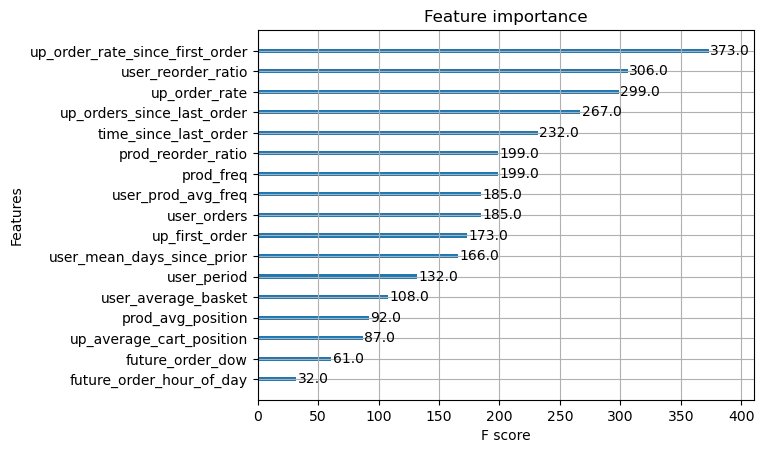

In [28]:
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectFromModel
# Visualizing the Feature importance 
print(clf.feature_importances_)

xgb.plot_importance(clf)
plt.show()

In [29]:
# keep probabilities for the positive outcome only

In [30]:
y_test_prob = clf.predict_proba(X_test)[:, 1]
y_val_prob = clf.predict_proba(X_val)[:, 1]
y_train_prob = clf.predict_proba(X_train)[:, 1]

In [31]:
def maximize_metric_keep_metric(metric1_list, metric2_list, metric2_thresh=0.3):
    for idx in range(len(metric1_list)):
        if(metric2_list[idx] > metric2_thresh):
            return idx
    return -1

In [86]:
from sklearn.metrics import precision_recall_curve

# Choosing Threshold that maximizes the f1_score
precision, recall, thresholds = precision_recall_curve(y_val, y_val_prob)
f1_scores = 2*recall*precision/(recall+precision)
opt_indx = np.argmax(f1_scores)
print("Maximuim f1_score: ", f1_scores[opt_indx])
print("Correspoding precision: ", precision[opt_indx])
print("Correspoding recall: ", recall[opt_indx])
print("Correspoding Threshold: ", thresholds[opt_indx])
best_thresh = thresholds[opt_indx]

Maximuim f1_score:  0.4400091343413475
Correspoding precision:  0.39710368822131925
Correspoding recall:  0.49330919617622276
Correspoding Threshold:  0.22040926


In [33]:
# Choosing Threshold that maximizes recall, while keeping precision above 0.3
opt_indx = maximize_metric_keep_metric(metric1_list=recall, metric2_list=precision, metric2_thresh=0.3)
print("Max recall for the positive class: ", recall[opt_indx])
print("Correspoding precision: ", precision[opt_indx])
print("Correspoding f1_score: ", f1_scores[opt_indx])
print("Correspoding Threshold: ", thresholds[opt_indx])
best_thresh = thresholds[opt_indx]

Max recall for the positive class:  0.6540820152644672
Correspoding precision:  0.30000036984573736
Correspoding f1_score:  0.41133732170544113
Correspoding Threshold:  0.13595219


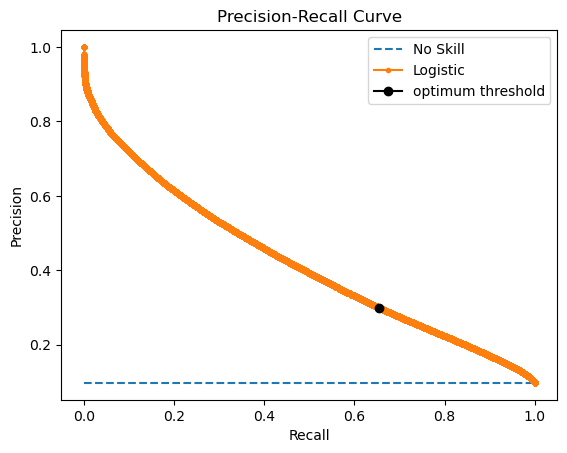

In [34]:
# plot the precision-recall curves
no_skill = len(y_val[y_val==1]) / len(y_val)
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
plt.plot(recall, precision, marker='.', label='Logistic')
plt.plot(recall[opt_indx], precision[opt_indx], marker='o', color='k', label='optimum threshold')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
# show the legend
plt.legend()
# show the plot
plt.show()

In [35]:
# Changing probabilities to predicted values, using the threshold obtained from the ROC-curve
y_test_preds = y_test_prob>best_thresh
y_val_preds = y_val_prob>best_thresh
y_train_preds = y_train_prob>best_thresh

In [36]:
from sklearn.metrics import confusion_matrix, classification_report
print("Train Set Report:",classification_report(y_train, y_train_preds))

print("Validation Set report:",classification_report(y_val, y_val_preds))

Train Set Report:               precision    recall  f1-score   support

         0.0       0.96      0.84      0.89   5351465
         1.0       0.30      0.65      0.41    580797

    accuracy                           0.82   5932262
   macro avg       0.63      0.74      0.65   5932262
weighted avg       0.89      0.82      0.85   5932262

Validation Set report:               precision    recall  f1-score   support

         0.0       0.96      0.84      0.89   2294372
         1.0       0.30      0.65      0.41    248027

    accuracy                           0.82   2542399
   macro avg       0.63      0.74      0.65   2542399
weighted avg       0.89      0.82      0.85   2542399



In [37]:
#Using Apriori Association rule

In [38]:
master_df = pd.concat([order_products_prior, order_products_train]).sort_values(by=['order_id'])

master_df = pd.merge(left = master_df, right = products,
                             left_on='product_id', right_on='product_id').sort_values(by=['order_id']).reset_index(drop=True)
master_df = pd.merge(left = master_df, right = aisles,
                             left_on='aisle_id', right_on='aisle_id').sort_values(by=['order_id']).reset_index(drop=True)
master_df = pd.merge(left = master_df, right = departments,
                             left_on='department_id', right_on='department_id').sort_values(by=['order_id']).reset_index(drop=True)
master_df = pd.merge(left = master_df, right = orders,
                             left_on='order_id', right_on='order_id').sort_values(by=['order_id']).reset_index(drop=True)


In [39]:
master_df.head(20)

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,aisle,department,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,1,49302,1,1,Bulgarian Yogurt,120,16,yogurt,dairy eggs,112108,train,4,4,10,9.0
1,1,49683,4,0,Cucumber Kirby,83,4,fresh vegetables,produce,112108,train,4,4,10,9.0
2,1,13176,6,0,Bag of Organic Bananas,24,4,fresh fruits,produce,112108,train,4,4,10,9.0
3,1,43633,5,1,Lightly Smoked Sardines in Olive Oil,95,15,canned meat seafood,canned goods,112108,train,4,4,10,9.0
4,1,10246,3,0,Organic Celery Hearts,83,4,fresh vegetables,produce,112108,train,4,4,10,9.0
5,1,47209,7,0,Organic Hass Avocado,24,4,fresh fruits,produce,112108,train,4,4,10,9.0
6,1,22035,8,1,Organic Whole String Cheese,21,16,packaged cheese,dairy eggs,112108,train,4,4,10,9.0
7,1,11109,2,1,Organic 4% Milk Fat Whole Milk Cottage Cheese,108,16,other creams cheeses,dairy eggs,112108,train,4,4,10,9.0
8,2,17794,6,1,Carrots,83,4,fresh vegetables,produce,202279,prior,3,5,9,8.0
9,2,30035,5,0,Natural Sweetener,17,13,baking ingredients,pantry,202279,prior,3,5,9,8.0


In [40]:
df = master_df[master_df['eval_set'] == 'train']
df

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,aisle,department,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,1,49302,1,1,Bulgarian Yogurt,120,16,yogurt,dairy eggs,112108,train,4,4,10,9.0
1,1,49683,4,0,Cucumber Kirby,83,4,fresh vegetables,produce,112108,train,4,4,10,9.0
2,1,13176,6,0,Bag of Organic Bananas,24,4,fresh fruits,produce,112108,train,4,4,10,9.0
3,1,43633,5,1,Lightly Smoked Sardines in Olive Oil,95,15,canned meat seafood,canned goods,112108,train,4,4,10,9.0
4,1,10246,3,0,Organic Celery Hearts,83,4,fresh vegetables,produce,112108,train,4,4,10,9.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33818974,3421063,49235,1,1,Organic Half & Half,53,16,cream,dairy eggs,169679,train,30,0,10,4.0
33818975,3421063,14233,3,1,Natural Artesian Water,115,7,water seltzer sparkling water,beverages,169679,train,30,0,10,4.0
33819017,3421070,16953,2,1,Creamy Peanut Butter,88,13,spreads,pantry,139822,train,15,6,10,8.0
33819018,3421070,35951,1,1,Organic Unsweetened Almond Milk,91,16,soy lactosefree,dairy eggs,139822,train,15,6,10,8.0


In [41]:
#the dataset is too large to run, even with gc.collect() so we use less than 10% of it.

In [42]:
df = df.head(10000)

In [43]:
#we create a basket to make predictions
#We only use the 100 most frequently bought products

In [44]:
product_counts = df.groupby('product_id')['order_id'].count().reset_index().rename(columns = {'order_id':'frequency'})
product_counts = product_counts.sort_values('frequency', ascending=False)[0:100].reset_index(drop=True)
product_counts

,product_id,frequency
0,24852,123
1,21137,98
2,13176,94
3,21903,70
4,47626,66
...,...,...
95,21288,11
96,8021,11
97,40604,11
98,27086,11


In [45]:
#Product ID of top 10 most Frequent products

In [46]:
freq_products = list(product_counts.product_id)
del product_counts 
freq_products[1:10]

[21137, 13176, 21903, 47626, 47209, 47766, 30391, 26209, 16797]

In [47]:
order_products = df[df.product_id.isin(freq_products)]
del df
order_products.shape

(2332, 15)

In [48]:
df=order_products[['order_id','product_name','reordered']].set_index('order_id')
df

,product_name,reordered
order_id,,
1,Cucumber Kirby,0
1,Bag of Organic Bananas,0
1,Organic Hass Avocado,0
1,Organic Whole String Cheese,1
36,Organic Garnet Sweet Potato (Yam),1
...,...,...
23886,Organic Strawberries,1
23886,Raspberries,1
23886,Organic Blueberries,1


In [49]:
import gc                         
gc.enable()

In [50]:
gc.collect()

9343

In [51]:
basket = df.pivot_table(columns='product_name', values='reordered', index='order_id').reset_index().fillna(0).set_index('order_id')
basket

product_name,100% Recycled Paper Towels,100% Whole Wheat Bread,Apple Honeycrisp Organic,Asparagus,Bag of Organic Bananas,Banana,Blackberries,Boneless Skinless Chicken Breasts,Broccoli Crown,Bunched Cilantro,...,Soda,Sparkling Lemon Water,Sparkling Natural Mineral Water,Sparkling Water Grapefruit,Spring Water,Strawberries,Uncured Genoa Salami,Unsalted Butter,Yellow Bell Pepper,Yellow Onions
order_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
36,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
38,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
96,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
98,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23813,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
23870,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
23886,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [52]:
def encode_units(x):
    if x <= 0:
        return 0
    if x >= 1:
        return 1
    
basket = basket.applymap(encode_units)
basket.head()

product_name,100% Recycled Paper Towels,100% Whole Wheat Bread,Apple Honeycrisp Organic,Asparagus,Bag of Organic Bananas,Banana,Blackberries,Boneless Skinless Chicken Breasts,Broccoli Crown,Bunched Cilantro,...,Soda,Sparkling Lemon Water,Sparkling Natural Mineral Water,Sparkling Water Grapefruit,Spring Water,Strawberries,Uncured Genoa Salami,Unsalted Butter,Yellow Bell Pepper,Yellow Onions
order_id,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
36,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
38,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
96,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
98,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [53]:
#Using only 10thousand records
shortbasket = basket[:10000]
shortbasket

product_name,100% Recycled Paper Towels,100% Whole Wheat Bread,Apple Honeycrisp Organic,Asparagus,Bag of Organic Bananas,Banana,Blackberries,Boneless Skinless Chicken Breasts,Broccoli Crown,Bunched Cilantro,...,Soda,Sparkling Lemon Water,Sparkling Natural Mineral Water,Sparkling Water Grapefruit,Spring Water,Strawberries,Uncured Genoa Salami,Unsalted Butter,Yellow Bell Pepper,Yellow Onions
order_id,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
36,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
38,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
96,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
98,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23813,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
23870,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
23886,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [54]:
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

#Any set of items which occur in atleast 1% of all transactions = min support (Can try a higher percentage later)
frequent_items = apriori(shortbasket, min_support=0.001, use_colnames=True , verbose =1 , low_memory=True)

# The length column has been added making it easier to filter.
frequent_items['length'] = frequent_items['itemsets'].apply(lambda x: len(x))
frequent_items

C:\Users\Don\anaconda3\lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:110: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


Processing 32 combinations | Sampling itemset size 15432


,support,itemsets,length
0,0.009160,(100% Recycled Paper Towels),1
1,0.022901,(100% Whole Wheat Bread),1
2,0.021374,(Apple Honeycrisp Organic),1
3,0.019847,(Asparagus),1
4,0.125191,(Bag of Organic Bananas),1
...,...,...,...
139609,0.001527,"(Limes, Organic Red Onion, Banana, Organic Avo...",14
139610,0.001527,"(Limes, Organic Red Onion, Organic Avocado, Gr...",14
139611,0.001527,"(Organic Garlic, Limes, Large Lemon, Organic G...",14
139612,0.001527,"(Organic Garlic, Limes, Large Lemon, Organic G...",15


In [55]:
import warnings
warnings.filterwarnings('ignore')

In [56]:
frequent_items[frequent_items['support'] == frequent_items.support.max()]

,support,itemsets,length
5,0.154198,(Banana),1


In [57]:
# the most 10 frequently occurring item in our dataset with item set of given length  
def most_10_frequent_items(length):
    return frequent_items.sort_values('support', ascending=False)[frequent_items['length'] == length].head(10)

In [58]:
# the most 10 frequently occurring item in our dataset with item set of length 1 
most_10_frequent_items(1)

,support,itemsets,length
5,0.154198,(Banana),1
4,0.125191,(Bag of Organic Bananas),1
71,0.116031,(Organic Strawberries),1
36,0.085496,(Organic Baby Spinach),1
27,0.067176,(Large Lemon),1
54,0.065649,(Organic Hass Avocado),1
32,0.048855,(Organic Avocado),1
62,0.047328,(Organic Raspberries),1
95,0.045802,(Strawberries),1
74,0.044275,(Organic Whole Milk),1


In [59]:
# the most 10 frequently occurring item in our dataset with 2 products

In [60]:
most_10_frequent_items(2)

,support,itemsets,length
283,0.025954,"(Bag of Organic Bananas, Organic Strawberries)",2
360,0.021374,"(Banana, Organic Strawberries)",2
334,0.021374,"(Banana, Organic Baby Spinach)",2
269,0.021374,"(Bag of Organic Bananas, Organic Hass Avocado)",2
875,0.018321,"(Large Lemon, Organic Baby Spinach)",2
252,0.018321,"(Bag of Organic Bananas, Organic Baby Spinach)",2
1184,0.015267,"(Organic Strawberries, Organic Baby Spinach)",2
1622,0.015267,"(Organic Strawberries, Organic Hass Avocado)",2
942,0.013740,"(Limes, Organic Avocado)",2
276,0.013740,"(Organic Raspberries, Bag of Organic Bananas)",2


In [61]:
# the most 10 frequently occurring item in our dataset with item set of length 3 

most_10_frequent_items(3)

,support,itemsets,length
4734,0.007634,"(Limes, Organic Avocado, Large Lemon)",3
6052,0.006107,"(Organic Garnet Sweet Potato (Yam), Organic Ha...",3
5189,0.006107,"(Limes, Organic Garnet Sweet Potato (Yam), Org...",3
2877,0.006107,"(Organic Large Extra Fancy Fuji Apple, Bag of ...",3
2528,0.006107,"(Organic Hass Avocado, Bag of Organic Bananas,...",3
2650,0.006107,"(Bag of Organic Bananas, Organic Strawberries,...",3
2921,0.006107,"(Bag of Organic Bananas, Organic Strawberries,...",3
5963,0.006107,"(Organic Strawberries, Organic Blackberries, O...",3
2639,0.006107,"(Bag of Organic Bananas, Organic Hass Avocado,...",3
2645,0.006107,"(Organic Raspberries, Bag of Organic Bananas, ...",3


In [62]:
# the most 10 frequently occurring item in our dataset with item set of length 4
most_10_frequent_items(4)

,support,itemsets,length
10199,0.004580,"(Organic Large Extra Fancy Fuji Apple, Bag of ...",4
15237,0.004580,"(Limes, Organic Garnet Sweet Potato (Yam), Red...",4
14358,0.004580,"(Organic Hass Avocado, Organic Raspberries, La...",4
9274,0.003053,"(Limes, Red Vine Tomato, Organic Strawberries,...",4
17668,0.003053,"(Organic Garnet Sweet Potato (Yam), Organic St...",4
17672,0.003053,"(Organic Granny Smith Apple, Organic Lemon, Or...",4
17673,0.003053,"(Organic Granny Smith Apple, Organic Strawberr...",4
11312,0.003053,"(Limes, Organic Ginger Root, Broccoli Crown, L...",4
17028,0.003053,"(Organic Raspberries, Organic Garnet Sweet Pot...",4
17029,0.003053,"(Organic Red Onion, Organic Garnet Sweet Potat...",4


In [63]:
#all items with a given length and at least support
def all_items_with_at_least_support_and_len(support , len):
    return frequent_items[ (frequent_items['length'] == len) & (frequent_items['support'] >= support) ]
    

In [64]:
#all items with a length of 2, and the minimum support is more than 0.02 (occur together in at least 2% of all transactions)

all_items_with_at_least_support_and_len(0.02 , 2)

,support,itemsets,length
269,0.021374,"(Bag of Organic Bananas, Organic Hass Avocado)",2
283,0.025954,"(Bag of Organic Bananas, Organic Strawberries)",2
334,0.021374,"(Banana, Organic Baby Spinach)",2
360,0.021374,"(Banana, Organic Strawberries)",2


In [65]:
#all items with a length of 1, and the minimum support is more than 0.1 (occur in at least 10% of all transactions)

all_items_with_at_least_support_and_len(0.1 , 1)

,support,itemsets,length
4,0.125191,(Bag of Organic Bananas),1
5,0.154198,(Banana),1
71,0.116031,(Organic Strawberries),1


In [66]:
# showing support of itemset of product
def show_itemset_support(frozenset):
    return frequent_items[ frequent_items['itemsets'] == frozenset ]
    

In [67]:
show_itemset_support({'Bag of Organic Bananas','Organic Hass Avocado'})

,support,itemsets,length
269,0.021374,"(Bag of Organic Bananas, Organic Hass Avocado)",2


In [68]:
show_itemset_support({'Organic Hass Avocado','Organic Raspberries','Organic Strawberries','Bag of Organic Bananas'})

,support,itemsets,length
10111,0.003053,"(Organic Raspberries, Bag of Organic Bananas, ...",4


In [69]:
#Support: This measure gives an idea of how frequent an item is in all the transactions.
#Confidence: This shows how likely item Y is purchased when item X is purchased. How strongly correlated they are.
#Lift: This shows likelyhood that item Y is purchased when item X is purchased, while controlling for how popular item Y is.
#Leverage : how different is the co-occurrence of the antecedent X and the consequent Y of a rule from independence.
#low confidence is likely due to few purchases of that product.

#left > 1 --> item Y is likely to be bought if item X is bought
#left < 1 --> item Y is unlikely to be bought if item X is bought.
#left = 1 --> which implies no association between items

In [70]:
frequent_items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 139614 entries, 0 to 139613
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   support   139614 non-null  float64
 1   itemsets  139614 non-null  object 
 2   length    139614 non-null  int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 3.2+ MB


In [71]:
#Using only less then 10% of this dataset since 100% did not run
frequent_items = frequent_items.head(10000)

In [72]:
# rules derived from the frequent itemsets only if the level of lift is above the 50 percent threshold
rules = association_rules(frequent_items, metric='lift', min_threshold=1.1)
rules["antecedent_len"] = rules["antecedents"].apply(lambda x: len(x))
rules

# left = 1 (likelyness of correlation)
# left = 1.1  (unlikelyness)
# left = .5 (No association) 

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric,antecedent_len
0,(100% Recycled Paper Towels),(100% Whole Wheat Bread),0.009160,0.022901,0.001527,0.166667,7.277778,0.001317,1.172519,0.870570,1
1,(100% Whole Wheat Bread),(100% Recycled Paper Towels),0.022901,0.009160,0.001527,0.066667,7.277778,0.001317,1.061614,0.882812,1
2,(Boneless Skinless Chicken Breasts),(100% Recycled Paper Towels),0.016794,0.009160,0.001527,0.090909,9.924242,0.001373,1.089924,0.914596,1
3,(100% Recycled Paper Towels),(Boneless Skinless Chicken Breasts),0.009160,0.016794,0.001527,0.166667,9.924242,0.001373,1.179847,0.907550,1
4,(Globe Eggplant),(100% Recycled Paper Towels),0.006107,0.009160,0.001527,0.250000,27.291667,0.001471,1.321120,0.969278,1
...,...,...,...,...,...,...,...,...,...,...,...
70933,"(Bag of Organic Bananas, Organic Hass Avocado)","(Organic Garnet Sweet Potato (Yam), Organic Zu...",0.021374,0.001527,0.001527,0.071429,46.785714,0.001494,1.075279,1.000000,2
70934,(Organic Garnet Sweet Potato (Yam)),"(Bag of Organic Bananas, Organic Zucchini, Org...",0.019847,0.001527,0.001527,0.076923,50.384615,0.001496,1.081679,1.000000,1
70935,(Organic Zucchini),"(Organic Garnet Sweet Potato (Yam), Organic Ha...",0.030534,0.004580,0.001527,0.050000,10.916667,0.001387,1.047810,0.937008,1
70936,(Organic Hass Avocado),"(Organic Garnet Sweet Potato (Yam), Organic Zu...",0.065649,0.001527,0.001527,0.023256,15.232558,0.001426,1.022246,1.000000,1


In [73]:
# rules that satisfy the following criteria: at least 2 antecedents , a confidence > 0.75 & a lift score > 1.2
rules[(rules['antecedent_len'] >= 1) &
       (rules['confidence'] >= .3) &
       (rules['lift'] >= 3) ]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric,antecedent_len
13,(100% Recycled Paper Towels),(Organic Banana),0.009160,0.016794,0.003053,0.333333,19.848485,0.002900,1.474809,0.958398,1
32,(100% Recycled Paper Towels),(Organic Ketchup),0.009160,0.006107,0.003053,0.333333,54.583333,0.002997,1.490840,0.990755,1
33,(Organic Ketchup),(100% Recycled Paper Towels),0.006107,0.009160,0.003053,0.500000,54.583333,0.002997,1.981679,0.987711,1
45,(100% Recycled Paper Towels),(Red Raspberries),0.009160,0.015267,0.003053,0.333333,21.833333,0.002914,1.477099,0.963020,1
48,(100% Recycled Paper Towels),(Small Hass Avocado),0.009160,0.030534,0.003053,0.333333,10.916667,0.002774,1.454198,0.916795,1
...,...,...,...,...,...,...,...,...,...,...,...
70926,"(Organic Garnet Sweet Potato (Yam), Organic Ha...",(Organic Zucchini),0.004580,0.030534,0.001527,0.333333,10.916667,0.001387,1.454198,0.912577,3
70927,"(Bag of Organic Bananas, Organic Zucchini, Org...",(Organic Garnet Sweet Potato (Yam)),0.001527,0.019847,0.001527,1.000000,50.384615,0.001496,inf,0.981651,3
70928,"(Organic Garnet Sweet Potato (Yam), Organic Zu...","(Bag of Organic Bananas, Organic Hass Avocado)",0.001527,0.021374,0.001527,1.000000,46.785714,0.001494,inf,0.980122,2
70931,"(Organic Zucchini, Organic Hass Avocado)","(Organic Garnet Sweet Potato (Yam), Bag of Org...",0.004580,0.007634,0.001527,0.333333,43.666667,0.001492,1.488550,0.981595,2


In [74]:
# sort rules ascending based on metric
def sorted_rules_asc_based_on_metric(metric='support'):
    return rules.sort_values(metric)

In [75]:
sorted_rules_asc_based_on_metric('lift')

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric,antecedent_len
1859,(Organic Blueberries),(Organic Baby Carrots),0.041221,0.033588,0.001527,0.037037,1.102694,0.000142,1.003582,0.097134,1
1858,(Organic Baby Carrots),(Organic Blueberries),0.033588,0.041221,0.001527,0.045455,1.102694,0.000142,1.004435,0.096367,1
2392,(Organic Raspberries),(Organic Fuji Apple),0.047328,0.029008,0.001527,0.032258,1.112054,0.000154,1.003359,0.105769,1
2393,(Organic Fuji Apple),(Organic Raspberries),0.029008,0.047328,0.001527,0.052632,1.112054,0.000154,1.005598,0.103774,1
408,(Banana),(Organic Whole Milk),0.154198,0.044275,0.007634,0.049505,1.118129,0.000806,1.005503,0.124910,1
...,...,...,...,...,...,...,...,...,...,...,...
48504,"(Granny Smith Apples, Organic Baby Spinach)","(Asparagus, Broccoli Crown)",0.001527,0.001527,0.001527,1.000000,655.000000,0.001524,inf,1.000000,2
40367,"(Organic Cilantro, Strawberries)","(100% Recycled Paper Towels, Organic Garlic)",0.001527,0.001527,0.001527,1.000000,655.000000,0.001524,inf,1.000000,2
40366,"(Organic Cilantro, 100% Recycled Paper Towels)","(Strawberries, Organic Garlic)",0.001527,0.001527,0.001527,1.000000,655.000000,0.001524,inf,1.000000,2
40385,"(Organic Tomato Cluster, Red Peppers)","(Organic Cilantro, 100% Recycled Paper Towels)",0.001527,0.001527,0.001527,1.000000,655.000000,0.001524,inf,1.000000,2


In [76]:
#rules['leverage'].min()
rules['lift'].min()
#rules['conviction'].min()
#rules['antecedent_len'].min()

1.1026936026936025

In [77]:
def rules_with_specific_threshold(support=.001,confidence=.005,lift=1.1,leverage=9.5e-05,conviction=1):
    return rules[ (rules['support'] >= support) &
       (rules['confidence'] >= confidence) &
       (rules['lift'] >= lift)&
       (rules['leverage'] >= leverage) &
       (rules['conviction'] >= conviction)]

In [78]:
rules_with_specific_threshold(support=.021,lift=1)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric,antecedent_len
302,(Bag of Organic Bananas),(Organic Hass Avocado),0.125191,0.065649,0.021374,0.170732,2.600681,0.013155,1.126718,0.703565,1
303,(Organic Hass Avocado),(Bag of Organic Bananas),0.065649,0.125191,0.021374,0.325581,2.600681,0.013155,1.297131,0.658730,1
326,(Bag of Organic Bananas),(Organic Strawberries),0.125191,0.116031,0.025954,0.207317,1.786746,0.011428,1.115161,0.503336,1
327,(Organic Strawberries),(Bag of Organic Bananas),0.116031,0.125191,0.025954,0.223684,1.786746,0.011428,1.126873,0.498120,1
386,(Banana),(Organic Baby Spinach),0.154198,0.085496,0.021374,0.138614,1.621287,0.008191,1.061665,0.453069,1
387,(Organic Baby Spinach),(Banana),0.085496,0.154198,0.021374,0.250000,1.621287,0.008191,1.127735,0.419032,1
406,(Banana),(Organic Strawberries),0.154198,0.116031,0.021374,0.138614,1.194633,0.003482,1.026217,0.192625,1
407,(Organic Strawberries),(Banana),0.116031,0.154198,0.021374,0.184211,1.194633,0.003482,1.036789,0.184308,1


In [79]:
def select_rules_with_antecedents_length(len):
    return rules[ rules['antecedent_len'] == len]

In [80]:
select_rules_with_antecedents_length(3)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric,antecedent_len
37478,"(100% Recycled Paper Towels, Globe Eggplant, G...",(100% Whole Wheat Bread),0.001527,0.022901,0.001527,1.000000,43.666667,0.001492,inf,0.978593,3
37479,"(100% Whole Wheat Bread, Globe Eggplant, Green...",(100% Recycled Paper Towels),0.001527,0.009160,0.001527,1.000000,109.166667,0.001513,inf,0.992355,3
37480,"(100% Recycled Paper Towels, Globe Eggplant, 1...",(Green Bell Pepper),0.001527,0.009160,0.001527,1.000000,109.166667,0.001513,inf,0.992355,3
37481,"(100% Whole Wheat Bread, 100% Recycled Paper T...",(Globe Eggplant),0.001527,0.006107,0.001527,1.000000,163.750000,0.001517,inf,0.995413,3
37492,"(100% Recycled Paper Towels, Organic Cilantro,...",(100% Whole Wheat Bread),0.001527,0.022901,0.001527,1.000000,43.666667,0.001492,inf,0.978593,3
...,...,...,...,...,...,...,...,...,...,...,...
70913,"(Bag of Organic Bananas, Organic Unsweetened A...",(Organic Garnet Sweet Potato (Yam)),0.001527,0.019847,0.001527,1.000000,50.384615,0.001496,inf,0.981651,3
70924,"(Organic Garnet Sweet Potato (Yam), Organic Zu...",(Bag of Organic Bananas),0.001527,0.125191,0.001527,1.000000,7.987805,0.001336,inf,0.876147,3
70925,"(Organic Garnet Sweet Potato (Yam), Organic Zu...",(Organic Hass Avocado),0.001527,0.065649,0.001527,1.000000,15.232558,0.001426,inf,0.935780,3
70926,"(Organic Garnet Sweet Potato (Yam), Organic Ha...",(Organic Zucchini),0.004580,0.030534,0.001527,0.333333,10.916667,0.001387,1.454198,0.912577,3


In [ ]:
####----------------------NOTE------------------####
####----------------------NOTE------------------####
####----------------------NOTE------------------####
#Due to the limited size of the dataset now, there is only a maximum of 4 products per basket. Try larger percentage of dataset
####----------------------NOTE------------------####
####----------------------NOTE------------------####
####----------------------NOTE------------------####

In [81]:
def select_rules_with_antecedents_names(names=set()):
    return rules[rules['antecedents'].apply(lambda x:  names in {x})]

In [82]:
#select_rules_with_antecedents_names({'Organic Hass Avocado'})
select_rules_with_antecedents_names({'Carrots'})

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric,antecedent_len
250,(Carrots),(Bag of Organic Bananas),0.021374,0.125191,0.004580,0.214286,1.711672,0.001904,1.113393,0.424857,1
572,(Carrots),(Bunched Cilantro),0.021374,0.009160,0.001527,0.071429,7.797619,0.001331,1.067058,0.890796,1
603,(Carrots),(Fresh Cauliflower),0.021374,0.022901,0.001527,0.071429,3.119048,0.001037,1.052261,0.694228,1
604,(Carrots),(Garlic),0.021374,0.012214,0.001527,0.071429,5.848214,0.001266,1.063770,0.847114,1
606,(Carrots),(Hass Avocados),0.021374,0.022901,0.001527,0.071429,3.119048,0.001037,1.052261,0.694228,1
...,...,...,...,...,...,...,...,...,...,...,...
13898,(Carrots),"(Organic Large Extra Fancy Fuji Apple, Organic...",0.021374,0.012214,0.001527,0.071429,5.848214,0.001266,1.063770,0.847114,1
13904,(Carrots),"(Unsalted Butter, Organic Strawberries)",0.021374,0.003053,0.001527,0.071429,23.392857,0.001461,1.073635,0.978159,1
13910,(Carrots),"(Sharp Cheddar Cheese, Organic Zucchini)",0.021374,0.004580,0.001527,0.071429,15.595238,0.001429,1.071991,0.956318,1
13916,(Carrots),"(Red Raspberries, Red Peppers)",0.021374,0.003053,0.001527,0.071429,23.392857,0.001461,1.073635,0.978159,1


In [99]:
#Experiment1

A = select_rules_with_antecedents_names({'Carrots'})
A

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric,antecedent_len
250,(Carrots),(Bag of Organic Bananas),0.021374,0.125191,0.004580,0.214286,1.711672,0.001904,1.113393,0.424857,1
572,(Carrots),(Bunched Cilantro),0.021374,0.009160,0.001527,0.071429,7.797619,0.001331,1.067058,0.890796,1
603,(Carrots),(Fresh Cauliflower),0.021374,0.022901,0.001527,0.071429,3.119048,0.001037,1.052261,0.694228,1
604,(Carrots),(Garlic),0.021374,0.012214,0.001527,0.071429,5.848214,0.001266,1.063770,0.847114,1
606,(Carrots),(Hass Avocados),0.021374,0.022901,0.001527,0.071429,3.119048,0.001037,1.052261,0.694228,1
...,...,...,...,...,...,...,...,...,...,...,...
13898,(Carrots),"(Organic Large Extra Fancy Fuji Apple, Organic...",0.021374,0.012214,0.001527,0.071429,5.848214,0.001266,1.063770,0.847114,1
13904,(Carrots),"(Unsalted Butter, Organic Strawberries)",0.021374,0.003053,0.001527,0.071429,23.392857,0.001461,1.073635,0.978159,1
13910,(Carrots),"(Sharp Cheddar Cheese, Organic Zucchini)",0.021374,0.004580,0.001527,0.071429,15.595238,0.001429,1.071991,0.956318,1
13916,(Carrots),"(Red Raspberries, Red Peppers)",0.021374,0.003053,0.001527,0.071429,23.392857,0.001461,1.073635,0.978159,1


In [106]:
#Top 5 consequents (recommendations) of adding Carrots to cart first
A.sort_values(by=['support']).tail(5)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric,antecedent_len
13759,(Carrots),"(Organic Grape Tomatoes, Organic Baby Spinach)",0.021374,0.012214,0.003053,0.142857,11.696429,0.002792,1.152417,0.934477,1
636,(Carrots),(Organic Strawberries),0.021374,0.116031,0.003053,0.142857,1.231203,0.000573,1.031298,0.191888,1
622,(Carrots),(Organic Grape Tomatoes),0.021374,0.041221,0.004580,0.214286,5.198413,0.003699,1.220264,0.825273,1
614,(Carrots),(Organic Baby Spinach),0.021374,0.085496,0.004580,0.214286,2.506378,0.002753,1.163914,0.614145,1
250,(Carrots),(Bag of Organic Bananas),0.021374,0.125191,0.004580,0.214286,1.711672,0.001904,1.113393,0.424857,1


In [108]:
#Experiment 2
B = select_rules_with_antecedents_names({'Carrots', 'Organic Strawberries'})
B

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric,antecedent_len
6402,"(Carrots, Organic Strawberries)",(Bag of Organic Bananas),0.003053,0.125191,0.001527,0.5,3.993902,0.001144,1.749618,0.751914,2
13847,"(Carrots, Organic Strawberries)",(Organic Grape Tomatoes),0.003053,0.041221,0.001527,0.5,12.129630,0.001401,1.917557,0.920368,2
13896,"(Carrots, Organic Strawberries)",(Organic Large Extra Fancy Fuji Apple),0.003053,0.032061,0.001527,0.5,15.595238,0.001429,1.935878,0.938744,2
13902,"(Carrots, Organic Strawberries)",(Unsalted Butter),0.003053,0.015267,0.001527,0.5,32.750000,0.001480,1.969466,0.972435,2
53459,"(Carrots, Organic Strawberries)","(Unsalted Butter, Bag of Organic Bananas)",0.003053,0.003053,0.001527,0.5,163.750000,0.001517,1.993893,0.996937,2


In [109]:
B.sort_values(by=['support']).tail(5)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric,antecedent_len
6402,"(Carrots, Organic Strawberries)",(Bag of Organic Bananas),0.003053,0.125191,0.001527,0.5,3.993902,0.001144,1.749618,0.751914,2
13847,"(Carrots, Organic Strawberries)",(Organic Grape Tomatoes),0.003053,0.041221,0.001527,0.5,12.129630,0.001401,1.917557,0.920368,2
13896,"(Carrots, Organic Strawberries)",(Organic Large Extra Fancy Fuji Apple),0.003053,0.032061,0.001527,0.5,15.595238,0.001429,1.935878,0.938744,2
13902,"(Carrots, Organic Strawberries)",(Unsalted Butter),0.003053,0.015267,0.001527,0.5,32.750000,0.001480,1.969466,0.972435,2
53459,"(Carrots, Organic Strawberries)","(Unsalted Butter, Bag of Organic Bananas)",0.003053,0.003053,0.001527,0.5,163.750000,0.001517,1.993893,0.996937,2


In [110]:
#Experiment 3
C = select_rules_with_antecedents_names({'Carrots', 'Organic Strawberries', 'Unsalted Butter'})
C

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric,antecedent_len
53452,"(Unsalted Butter, Carrots, Organic Strawberries)",(Bag of Organic Bananas),0.001527,0.125191,0.001527,1.0,7.987805,0.001336,inf,0.876147,3


In [ ]:
# This should signify that if a person buys carrots first, they would normally only have a maximum of 4 items in their basket.

In [ ]:
#Lets look at this with bananas instead, since we know bananas are the most bought item

In [111]:
#Experiment 4
D = select_rules_with_antecedents_names({'Banana'})
D

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric,antecedent_len
179,(Banana),(Asparagus),0.154198,0.019847,0.006107,0.039604,1.995430,0.003046,1.020571,0.589801,1
358,(Banana),(Boneless Skinless Chicken Breasts),0.154198,0.016794,0.003053,0.019802,1.179118,0.000464,1.003069,0.179603,1
360,(Banana),(Bunched Cilantro),0.154198,0.009160,0.003053,0.019802,2.161716,0.001641,1.010857,0.635379,1
363,(Banana),(Cucumber Kirby),0.154198,0.021374,0.004580,0.029703,1.389675,0.001284,1.008584,0.331528,1
364,(Banana),(Fresh Cauliflower),0.154198,0.022901,0.006107,0.039604,1.729373,0.002576,1.017392,0.498646,1
...,...,...,...,...,...,...,...,...,...,...,...
48411,(Banana),"(Spring Water, Asparagus, Organic Cilantro)",0.154198,0.001527,0.001527,0.009901,6.485149,0.001291,1.008458,1.000000,1
48423,(Banana),"(Raspberries, Asparagus, Organic Cucumber)",0.154198,0.001527,0.001527,0.009901,6.485149,0.001291,1.008458,1.000000,1
48438,(Banana),"(Spring Water, Asparagus, Organic Cucumber)",0.154198,0.001527,0.001527,0.009901,6.485149,0.001291,1.008458,1.000000,1
48451,(Banana),"(Asparagus, Organic Strawberries, Small Hass A...",0.154198,0.001527,0.001527,0.009901,6.485149,0.001291,1.008458,1.000000,1


In [114]:
D.sort_values(by=['support']).tail(5)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric,antecedent_len
394,(Banana),(Organic Fuji Apple),0.154198,0.029008,0.009160,0.059406,2.047942,0.004687,1.032318,0.604994,1
424,(Banana),(Strawberries),0.154198,0.045802,0.009160,0.059406,1.297030,0.002098,1.014464,0.270758,1
377,(Banana),(Honeycrisp Apple),0.154198,0.024427,0.010687,0.069307,2.837252,0.006920,1.048222,0.765601,1
386,(Banana),(Organic Baby Spinach),0.154198,0.085496,0.021374,0.138614,1.621287,0.008191,1.061665,0.453069,1
406,(Banana),(Organic Strawberries),0.154198,0.116031,0.021374,0.138614,1.194633,0.003482,1.026217,0.192625,1


In [115]:
#Experiment 5
E = select_rules_with_antecedents_names({'Banana','Strawberries'})
E

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric,antecedent_len
9689,"(Banana, Strawberries)",(Cherubs Heavenly Salad Tomatoes),0.00916,0.012214,0.001527,0.166667,13.645833,0.001415,1.185344,0.935285,2
9750,"(Banana, Strawberries)",(Cucumber Kirby),0.00916,0.021374,0.001527,0.166667,7.797619,0.001331,1.174351,0.879815,2
10230,"(Banana, Strawberries)",(Honeycrisp Apple),0.00916,0.024427,0.003053,0.333333,13.645833,0.002830,1.463359,0.935285,2
10570,"(Banana, Strawberries)",(Limes),0.00916,0.041221,0.001527,0.166667,4.043210,0.001149,1.150534,0.759630,2
10606,"(Banana, Strawberries)",(Orange Bell Pepper),0.00916,0.009160,0.001527,0.166667,18.194444,0.001443,1.189008,0.953775,2
10727,"(Banana, Strawberries)",(Organic Baby Arugula),0.00916,0.021374,0.001527,0.166667,7.797619,0.001331,1.174351,0.879815,2
10958,"(Banana, Strawberries)",(Organic Baby Spinach),0.00916,0.085496,0.003053,0.333333,3.898810,0.002270,1.371756,0.750385,2
11285,"(Banana, Strawberries)",(Organic Fuji Apple),0.00916,0.029008,0.001527,0.166667,5.745614,0.001261,1.165191,0.833590,2
11405,"(Banana, Strawberries)",(Organic Garnet Sweet Potato (Yam)),0.00916,0.019847,0.001527,0.166667,8.397436,0.001345,1.176183,0.889060,2
11706,"(Banana, Strawberries)",(Original Hummus),0.00916,0.016794,0.001527,0.166667,9.924242,0.001373,1.179847,0.907550,2


In [116]:
E.sort_values(by=['support']).tail(5)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric,antecedent_len
11747,"(Banana, Strawberries)",(Red Vine Tomato),0.00916,0.022901,0.001527,0.166667,7.277778,0.001317,1.172519,0.870570,2
11784,"(Banana, Strawberries)",(Sparkling Water Grapefruit),0.00916,0.030534,0.001527,0.166667,5.458333,0.001247,1.163359,0.824345,2
11789,"(Banana, Strawberries)",(Yellow Onions),0.00916,0.022901,0.001527,0.166667,7.277778,0.001317,1.172519,0.870570,2
10230,"(Banana, Strawberries)",(Honeycrisp Apple),0.00916,0.024427,0.003053,0.333333,13.645833,0.002830,1.463359,0.935285,2
10958,"(Banana, Strawberries)",(Organic Baby Spinach),0.00916,0.085496,0.003053,0.333333,3.898810,0.002270,1.371756,0.750385,2


In [83]:
def select_rules_with_consequents_names(names=set()):
    return rules[rules['consequents'].apply(lambda x:  names in {x})]

In [84]:
#select_rules_with_consequents_names({'Organic Hass Avocado'})
select_rules_with_consequents_names({'Carrots'})

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric,antecedent_len
251,(Bag of Organic Bananas),(Carrots),0.125191,0.021374,0.004580,0.036585,1.711672,0.001904,1.015789,0.475276,1
573,(Bunched Cilantro),(Carrots),0.009160,0.021374,0.001527,0.166667,7.797619,0.001331,1.174351,0.879815,1
602,(Fresh Cauliflower),(Carrots),0.022901,0.021374,0.001527,0.066667,3.119048,0.001037,1.048528,0.695312,1
605,(Garlic),(Carrots),0.012214,0.021374,0.001527,0.125000,5.848214,0.001266,1.118430,0.839258,1
607,(Hass Avocados),(Carrots),0.022901,0.021374,0.001527,0.066667,3.119048,0.001037,1.048528,0.695312,1
...,...,...,...,...,...,...,...,...,...,...,...
13895,"(Organic Large Extra Fancy Fuji Apple, Organic...",(Carrots),0.012214,0.021374,0.001527,0.125000,5.848214,0.001266,1.118430,0.839258,2
13901,"(Unsalted Butter, Organic Strawberries)",(Carrots),0.003053,0.021374,0.001527,0.500000,23.392857,0.001461,1.957252,0.960184,2
13907,"(Sharp Cheddar Cheese, Organic Zucchini)",(Carrots),0.004580,0.021374,0.001527,0.333333,15.595238,0.001429,1.467939,0.940184,2
13913,"(Red Raspberries, Red Peppers)",(Carrots),0.003053,0.021374,0.001527,0.500000,23.392857,0.001461,1.957252,0.960184,2
